<a href="https://colab.research.google.com/github/varma1/NLP/blob/master/News_Analysis_AO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the Data 

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
!ls -ls /content/gdrive/'My Drive'/'Colab Notebooks'

ls: cannot access '/content/gdrive/My Drive/Colab Notebooks': No such file or directory


In [9]:
!cp "/content/gdrive/My Drive/Colab Notebooks/News_Category_Dataset_v2.json" "News_Category_Dataset_v2.json"

cp: cannot stat '/content/gdrive/My Drive/Colab Notebooks/News_Category_Dataset_v2.json': No such file or directory


#### Load libraries we will need 

In [0]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.linear_model import SGDClassifier
import logging
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [12]:
df_news = pd.read_json("/content/gdrive/My Drive/Colab Notebooks/News_Category_Dataset_v2.json", lines = True)
df_news.columns

Index(['authors', 'category', 'date', 'headline', 'link', 'short_description'], dtype='object')

In [13]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
authors              200853 non-null object
category             200853 non-null object
date                 200853 non-null datetime64[ns]
headline             200853 non-null object
link                 200853 non-null object
short_description    200853 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [14]:
df_news.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


Category Distribution

In [15]:
len(df_news['category'].unique())

41

In [16]:
print(df_news['category'].unique())

['CRIME' 'ENTERTAINMENT' 'WORLD NEWS' 'IMPACT' 'POLITICS' 'WEIRD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'SCIENCE' 'LATINO VOICES' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'WELLNESS' 'PARENTING' 'HOME & LIVING' 'STYLE & BEAUTY' 'DIVORCE'
 'WEDDINGS' 'FOOD & DRINK' 'MONEY' 'ENVIRONMENT' 'CULTURE & ARTS']


There are 41 categories in the dataset

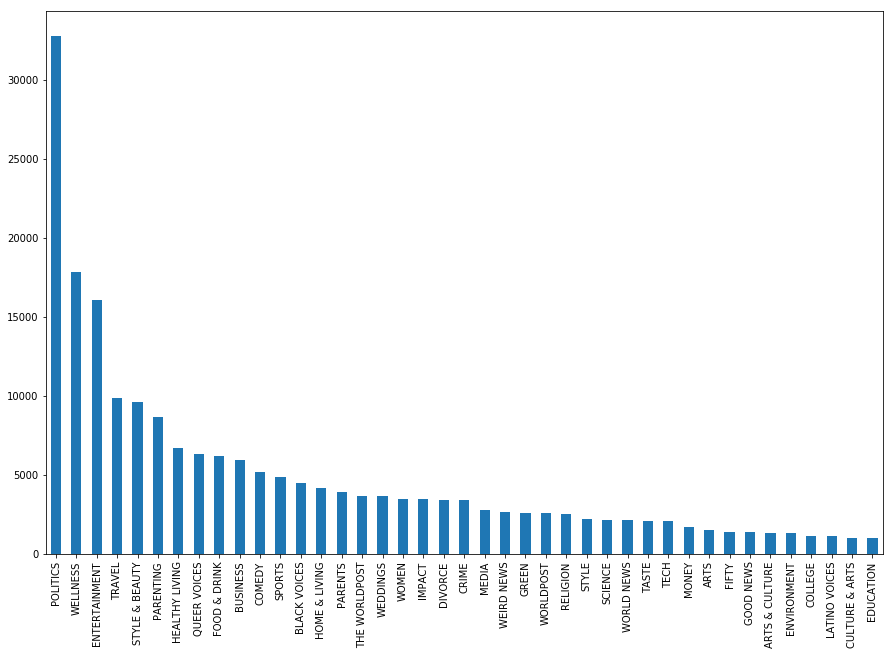

In [17]:
df_news['category'].value_counts().plot( kind='bar', figsize=(15,10))

#### Data pre-processing

load the nltk utilities

In [18]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

#### Function to clean, tokenize, remove stop word, and not alphanumeric from data

In [0]:
stop_words_ = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

custom_stop_words_ = ['make', 'amp',  'news','new' ,'time', 'u','s', 'photos',  'get', 'say']
def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2 and token not in custom_stop_words_
  
  
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text)
  text=re.sub("(\\d|\\W)+"," ",text)    
  clean_text = [ lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
  #print(clean_text)
  clean_text2 = [word for word in clean_text if black_txt(word)]
  #print(clean_text2)
  return " ".join(clean_text2)

In [20]:
df_news.short_description[2]

'The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.'

#### Processing the Data and TF-IDF

We need to merge the categories _WORDLPOST_ with _THE WORDPOST_, because there *are* basically the same, next we combine the columns _headline with _short_description_ these are our predictor text

In [0]:
df_news.category = df_news.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [0]:
df_news['text'] = df_news['headline'] + " " + df_news['short_description']

In [23]:
df_news.text[10]

'Justin Timberlake Visits Texas School Shooting Victims The pop star also wore a "Santa Fe Strong" shirt at his show in Houston.'

In [24]:
clean_txt(df_news.text[11])

'south korean president meet north koreas kim jong talk trump summit two meet pave way summit north korean'

In [25]:
clean_txt(df_news.text[5])

'morgan freeman devastate sexual harassment claim could undermine legacy right equate horrific incidents sexual assault misplace compliment humor statement'

#### Next we are going to create some news variables columns to try to improve the quaity of our classifier, we will create:
 * Polarity: to check the sentiment of the text
 * Subjectivity: to check if text is objective or subjective
 * The number of word in the text

In [26]:
blob = TextBlob((df_news.text[1]))
str(blob.correct())

"Will Smith Coins Diplo And Sick Am For The 2018 World Up's Official Long Of course it has a song."

In [0]:
def polarity_txt(text):
  return TextBlob(text).sentiment[0] 

In [0]:
def subj_txt(text):
  return  TextBlob(text).sentiment[1]

In [0]:
def len_text(text):
  if len(text.split())>0:
         return len(set(clean_txt(text).split()))/ len(text.split())
  else:
         return 0

In [30]:
df_news['polarity'] = df_news['text'].apply(polarity_txt)
df_news.head(2)

,authors,category,date,headline,link,short_description,text,polarity
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...,-0.05
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...,0.00


In [31]:
df_news['subjectivity'] = df_news['text'].apply(subj_txt)
df_news.head(2)

,authors,category,date,headline,link,short_description,text,polarity,subjectivity
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...,-0.05,0.266667
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...,0.00,0.000000


In [32]:
df_news['len'] = df_news['text'].apply(len_text)
df_news.head(2)

,authors,category,date,headline,link,short_description,text,polarity,subjectivity,len
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...,-0.05,0.266667,0.444444
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...,0.00,0.000000,0.500000


In [33]:
data = df_news.head(1)
{'pos':  data['polarity'].values[0], 'sub': data['subjectivity'].values[0],  'len': data['len'].values[0]} 

{'len': 0.4444444444444444, 'pos': -0.05, 'sub': 0.26666666666666666}

#### Make the Custom class for feature union Transformer of sklearn

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{'pos':  row['polarity'], 'sub': row['subjectivity'],  'len': row['len']} for _, row in data.iterrows()]


### Make our Custom Pipeline

In [0]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text
            ('text', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 10), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)),
            ])),

            # Pipeline for pulling metadata features
            ('stats', Pipeline([
                ('selector', ItemSelector(key=['polarity', 'subjectivity', 'len'])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'text': 0.9,
            'stats': 1.5,
        },
    ))
])

##### Build the pipeline

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
seed = 40
X = df_news[['text', 'polarity', 'subjectivity','len']]
y =df_news['category']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [37]:
pipeline.fit(x_train)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ItemSelector(key='text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                                                  encoding='utf-8',
                      

### Transform and train the ML models

In [38]:
%%time
train_vec = pipeline.transform(x_train)
test_vec = pipeline.transform(x_test)
print("Checking that the number of features in train and test correspond: %s - %s" % (train_vec.shape, test_vec.shape))

Checking that the number of features in train and test correspond: (160682, 189409) - (40171, 189409)
CPU times: user 1min 53s, sys: 101 ms, total: 1min 53s
Wall time: 1min 53s


In [0]:
clf_sv = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40, max_iter=10000) #Support Vector machines
clf_sgd = SGDClassifier(max_iter=200,) # Stochastic Gradient Classifier

In [40]:
%%time
from sklearn.model_selection import cross_val_score

clfs = [clf_sv, clf_sgd]
cv = 3
for clf in clfs:
    scores = cross_val_score(clf,train_vec, y_train, cv=cv, scoring="accuracy" )
    print (scores)
    print (("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), np.std(scores)))

[0.60213167 0.60403637 0.60228589]
Mean score: 0.603 (+/-0.001)
[0.58182293 0.58075537 0.57257311]
Mean score: 0.578 (+/-0.004)
CPU times: user 2min 43s, sys: 10.5 s, total: 2min 54s
Wall time: 2min 40s


In [41]:
%%time
from sklearn.metrics import classification_report
clf_sv.fit(train_vec, y_train )
y_pred = clf_sv.predict(test_vec)
list_result =[]
list_result.append(("SVC",accuracy_score(y_test, y_pred)))
clf_sgd.fit(train_vec, y_train )
y_pred = clf_sgd.predict(test_vec)
list_result.append(("SGD",accuracy_score(y_test, y_pred)))

print(list_result)


[('SVC', 0.6134773841826193), ('SGD', 0.5806925393940903)]
CPU times: user 1min 33s, sys: 3.5 s, total: 1min 37s
Wall time: 1min 32s


### Deep Learning and Spacy Models

In [42]:
import spacy
!python -m spacy download en_core_web_lg



    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [0]:
nlp = spacy.load('en_core_web_lg')

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Embedding
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

In [0]:
from sklearn.model_selection import train_test_split
import time
X = df_news['text']
y =df_news['category']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
# `to_categorical` converts this into a matrix with as many columns as there are classes. 
Y = np_utils.to_categorical(y)
##Create the tf-idf vector
vectorizer = TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = None, preprocessor=clean_txt)





In [46]:
seed = 40
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, stratify =y)
#Learn vocabulary and idf from training set
vectorizer.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.2, max_features=None,
                min_df=3, ngram_range=(1, 1), norm='l2',
                preprocessor=<function clean_txt at 0x7f2e15e82f28>,
                smooth_idf=1, stop_words=None, strip_accents='unicode',
                sublinear_tf=1, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=1, vocabulary=None)

In [47]:
print(x_train.shape)
print(x_train)
#print(x_train[:2])

(160682,)
36727     The Obamas Head Straight To Palm Springs For A...
80533     What The Marijuana Lobby Could Offer Hillary C...
16110     GOP Senators Are Pushing Lisa Murkowski For A ...
37325     Rep. John Lewis: Trump Is Not A 'Legitimate Pr...
54162     Feds Move To Block North Carolina From Enforci...
95519     Israel and Her Minorities If Israel wishes to ...
59447     Kentucky Derby Favorite Nyquist Looks To Follo...
16605     Alaska Road Trip Offers A Rare Look At The Las...
29499     Civility Strikes Back Style and substance are ...
25390     Reporter Out At Denver Post After 'Unacceptabl...
168858    Rebecca O'Grady and Orion Kirkpatrick: How We ...
37990     Zoe Saldana Goes Unfiltered About Her 'Gangste...
108267    WATCH: Marshawn Lynch Wants Nothing To Do With...
28180     ‘Spoiling The Belly’: The Dangers Of Backstree...
44021     Even The Military Is Sick Of EpiPen's Price Hi...
82329     Meet The Amazing Woman Who Created Her Family ...
73556     If We’re Going To En

In [48]:

word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()

#to_sequence function returns index of each word(as in word2idx) in a sentence.i.e we are converting words into numbers.
def to_sequence(tokenizer, preprocessor, index, text):
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    return indexes

X_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_train]
print(X_train_sequences[0])
 

[18668, 11954, 25588, 19448, 25191, 20685, 29263, 12600, 28350, 25877, 24540, 27487, 24293]


In [49]:
# Compute the max lenght of a text

MAX_SEQ_LENGHT=60

N_FEATURES = len(vectorizer.get_feature_names())
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
print(X_train_sequences[0])
 

[29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942
 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942
 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942
 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 18668
 11954 25588 19448 25191 20685 29263 12600 28350 25877 24540 27487 24293]


In [0]:
X_test_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_test]
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
 

#### Making the spacy embeding

In [51]:
#The en_core_web_lg has 300 dimensions. So we are initializing EMBEDDINGS_LEN=300
EMBEDDINGS_LEN = 300

embeddings_index = np.zeros((len(vectorizer.get_feature_names()) + 1, EMBEDDINGS_LEN))
for word, idx in word2idx.items():
    try:
        embedding = nlp.vocab[word].vector
        embeddings_index[idx] = embedding
    except:
        pass
      
print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)   
      

EMBEDDINGS_LEN= 300


In [52]:
#print(len(vectorizer.get_feature_names()))
print(nlp.vocab["russian"].vector.shape)

(300,)


#### Simple LSTM Model

In [53]:
 
model = Sequential()
model.add(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))
model.add(LSTM(300, dropout=0.2))
model.add(Dense(len(set(y)), activation='softmax'))
 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 300)           8982900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 40)                12040     
Total params: 9,716,140
Trainable params: 733,240
Non-trainable params: 8,982,900
_________________________________________________________________
None


In [54]:
model.fit(X_train_sequences, y_train, 
          epochs=5, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate(X_test_sequences, y_test, verbose=1)
print("Accuracy:", scores[1])
print("Accuracy:", scores[:])#
list_result.append(("LSTM Simple", scores[1]))

Instructions for updating:
Use tf.cast instead.
Train on 144613 samples, validate on 16069 samples
Epoch 1/5
144613/144613 [==============================] - 111s 765us/step - loss: 1.5839 - acc: 0.5595 - val_loss: 1.3304 - val_acc: 0.6177
Epoch 2/5
144613/144613 [==============================] - 110s 763us/step - loss: 1.2761 - acc: 0.6266 - val_loss: 1.2465 - val_acc: 0.6371
Epoch 3/5
144613/144613 [==============================] - 112s 773us/step - loss: 1.1642 - acc: 0.6519 - val_loss: 1.2171 - val_acc: 0.6440
Epoch 4/5
144613/144613 [==============================] - 111s 769us/step - loss: 1.0761 - acc: 0.6728 - val_loss: 1.2062 - val_acc: 0.6455
Epoch 5/5
40171/40171 [==============================] - 46s 1ms/step
Accuracy: 0.6445445719534091


In [55]:
len(x_train.keys())

160682

### Model LSTM and concatenate new columns

In [59]:
#LSTM adding the metadata features(Polarity,Subjectivity,Len)
from keras.models import Model
from keras.layers import Dense ,LSTM,concatenate,Input,Flatten,BatchNormalization, GRU

text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(3,), name = 'meta')
x=(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))(text_data)
x2 = ((LSTM(300, dropout=0.2, recurrent_dropout=0.2)))(x)
x4 = concatenate([x2, meta_data])
x5 = Dense(150, activation='relu')(x4)
x6 = Dropout(0.25)(x5)
x7 = BatchNormalization()(x6)
out=(Dense(len(set(y)), activation="softmax"))(x7)
model = Model(inputs=[text_data, meta_data ], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 60, 300)      8982900     text[0][0]                       
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 300)          721200      embedding_5[0][0]                
__________________________________________________________________________________________________
meta (InputLayer)               (None, 3)            0                                            
__________________________________________________________________________________________________
concatenat

In [0]:
df_cat_train = df_news.iloc[x_train.index][['polarity', 'subjectivity', 'len']]
df_cat_test = df_news.iloc[x_test.index][['polarity', 'subjectivity', 'len']]

In [61]:
model.fit([X_train_sequences, df_cat_train], y_train, 
          epochs=12, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate([X_test_sequences, df_cat_test],y_test, verbose=1)
print("Accuracy:", scores[1])  
list_result.append(("LSTM with Multi-Input", scores[1]))

Train on 144613 samples, validate on 16069 samples
Epoch 1/12
144613/144613 [==============================] - 117s 809us/step - loss: 1.7640 - acc: 0.5260 - val_loss: 1.3570 - val_acc: 0.6143
Epoch 2/12
144613/144613 [==============================] - 116s 800us/step - loss: 1.3925 - acc: 0.6057 - val_loss: 1.2746 - val_acc: 0.6289
Epoch 3/12
144613/144613 [==============================] - 115s 793us/step - loss: 1.2838 - acc: 0.6289 - val_loss: 1.2421 - val_acc: 0.6388
Epoch 4/12
144613/144613 [==============================] - 115s 796us/step - loss: 1.2099 - acc: 0.6440 - val_loss: 1.2118 - val_acc: 0.6506
Epoch 5/12
144613/144613 [==============================] - 114s 788us/step - loss: 1.1452 - acc: 0.6592 - val_loss: 1.2021 - val_acc: 0.6478
Epoch 6/12
144613/144613 [==============================] - 114s 788us/step - loss: 1.0893 - acc: 0.6720 - val_loss: 1.2034 - val_acc: 0.6487
Epoch 7/12
144613/144613 [==============================] - 114s 787us/step - loss: 1.0394 - acc:

### Model with 2 GRU (Bi-GRU)

In [62]:
#let us experiment by replacing LSTM with 2 GRU units 
text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(3,), name = 'meta')
x=(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))(text_data)
x2 = ((GRU(128, dropout=0.2, recurrent_dropout=0.2,  return_sequences=True)))(x)
x3 = ((GRU(128, dropout=0.2, recurrent_dropout=0.2)))(x2)
x4 = concatenate([x3, meta_data])
x5 = Dense(150, activation='relu')(x4)
x6 = Dropout(0.25)(x5)
x7 = BatchNormalization()(x6)
out=(Dense(len(set(y)), activation="softmax"))(x7)
model = Model(inputs=[text_data, meta_data ], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 60, 300)      8982900     text[0][0]                       
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 60, 128)      164736      embedding_6[0][0]                
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 128)          98688       gru_1[0][0]                      
__________________________________________________________________________________________________
meta (Inpu

In [63]:
model.fit([X_train_sequences, df_cat_train], y_train, 
          epochs=20, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate([X_test_sequences, df_cat_test],y_test, verbose=1)
print("Accuracy:", scores[1])  # 
list_result.append(("Bi-GRU", scores[1]))

Train on 144613 samples, validate on 16069 samples
Epoch 1/20
144613/144613 [==============================] - 198s 1ms/step - loss: 1.9079 - acc: 0.4948 - val_loss: 1.4263 - val_acc: 0.5973
Epoch 2/20
144613/144613 [==============================] - 194s 1ms/step - loss: 1.5081 - acc: 0.5800 - val_loss: 1.3309 - val_acc: 0.6211
Epoch 3/20
144613/144613 [==============================] - 193s 1ms/step - loss: 1.4140 - acc: 0.6003 - val_loss: 1.2877 - val_acc: 0.6307
Epoch 4/20
144613/144613 [==============================] - 193s 1ms/step - loss: 1.3603 - acc: 0.6129 - val_loss: 1.2618 - val_acc: 0.6361
Epoch 5/20
144613/144613 [==============================] - 193s 1ms/step - loss: 1.3152 - acc: 0.6218 - val_loss: 1.2404 - val_acc: 0.6396
Epoch 6/20
144613/144613 [==============================] - 194s 1ms/step - loss: 1.2822 - acc: 0.6289 - val_loss: 1.2387 - val_acc: 0.6416
Epoch 7/20
144613/144613 [==============================] - 197s 1ms/step - loss: 1.2581 - acc: 0.6359 - val_

## LSTM with Attention

In [65]:
             
             
             
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    

text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(3,), name = 'meta')
x = Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False)(text_data)
x1 = (LSTM(300, dropout=0.25, recurrent_dropout=0.25, return_sequences=True))(x)
x2 = Dropout(0.25)(x1)
x3 = Attention(MAX_SEQ_LENGHT)(x2)
x4 = Dense(256, activation='relu')(x3)
x5 = Dropout(0.25)(x4)
x6 = BatchNormalization()(x5)
x7 = concatenate([x6, meta_data])
x8 = Dense(150, activation='relu')(x7)
x9 = Dropout(0.25)(x8)
x10 = BatchNormalization()(x8)
outp = Dense(len(set(y)), activation='softmax')(x10)

AttentionLSTM = Model(inputs= [text_data, meta_data], outputs=outp)
AttentionLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

AttentionLSTM.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 60, 300)      8982900     text[0][0]                       
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 60, 300)      721200      embedding_8[0][0]                
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 60, 300)      0           lstm_4[0][0]                     
__________________________________________________________________________________________________
attention_

In [66]:
AttentionLSTM.fit([X_train_sequences, df_cat_train], y_train, 
          epochs=13, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = AttentionLSTM.evaluate([X_test_sequences, df_cat_test],y_test, verbose=1)
print("Accuracy:", scores[1])  # 
list_result.append(("LSTM with Attention", scores[1]))

Train on 144613 samples, validate on 16069 samples
Epoch 1/13
144613/144613 [==============================] - 123s 854us/step - loss: 1.7261 - acc: 0.5322 - val_loss: 1.3839 - val_acc: 0.6036
Epoch 2/13
144613/144613 [==============================] - 121s 840us/step - loss: 1.4100 - acc: 0.5980 - val_loss: 1.2959 - val_acc: 0.6232
Epoch 3/13
144613/144613 [==============================] - 120s 831us/step - loss: 1.3153 - acc: 0.6185 - val_loss: 1.2371 - val_acc: 0.6374
Epoch 4/13
144613/144613 [==============================] - 120s 829us/step - loss: 1.2440 - acc: 0.6341 - val_loss: 1.2078 - val_acc: 0.6452
Epoch 5/13
144613/144613 [==============================] - 120s 831us/step - loss: 1.1914 - acc: 0.6471 - val_loss: 1.1911 - val_acc: 0.6464
Epoch 6/13
144613/144613 [==============================] - 120s 827us/step - loss: 1.1447 - acc: 0.6582 - val_loss: 1.1739 - val_acc: 0.6562
Epoch 7/13
144613/144613 [==============================] - 120s 831us/step - loss: 1.1028 - acc:

##  Models Comparison

In [67]:
pd.DataFrame(list_result, columns=['model', 'accuracy'])

,model,accuracy
0,SVC,0.613477
1,SGD,0.580693
2,LSTM Simple,0.644545
3,LSTM with Multi-Input,0.647283
4,Bi-GRU,0.652038
5,LSTM with Attention,0.658410
